# Prediction of Health Insurance Cost by Linear Regression

### Loading the libraries and modules

In [ ]:
import pandas as pd
import numpy as np
import scipy as sp
import sklearn as sk
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import cross_val_score, KFold
from sklearn import model_selection
from sklearn import linear_model
from sklearn.metrics import mean_squared_error,mean_absolute_error

### Loading the data

In [ ]:
from google.colab import files
uploaded = files.upload()
insurance = pd.read_csv('insurance.csv')
insurance.info()

Saving insurance.csv to insurance.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


#### First, we define a function to distinguish smokers and non-smokers


In [ ]:
def map_smoking(column):
    mapped=[]
    
    for row in column:
        
        if row=="yes":
            mapped.append(1)
        else:
            mapped.append(0)
        
        
    return mapped
insurance["smoker_norm"]=map_smoking(insurance["smoker"])

In [ ]:
nonnum_cols=[col for col in insurance.select_dtypes(include=["object"])]


#### Also, we will create a new feature that distinguishes obese and non-obese individuals

In [ ]:
def map_obese(column):
    mapped=[]
    for row in column:
        if row>30:
            mapped.append(1)
        else:
            mapped.append(0)
    return mapped
insurance["obese"]=map_obese(insurance["bmi"])

In [ ]:
insurance.head(5)

,age,sex,bmi,children,smoker,region,charges,smoker_norm,obese
0,19,female,27.900,0,yes,southwest,16884.92400,1,0
1,18,male,33.770,1,no,southeast,1725.55230,0,1
2,28,male,33.000,3,no,southeast,4449.46200,0,1
3,33,male,22.705,0,no,northwest,21984.47061,0,0
4,32,male,28.880,0,no,northwest,3866.85520,0,0


### We now explore the relation between the features given and the insurance costs

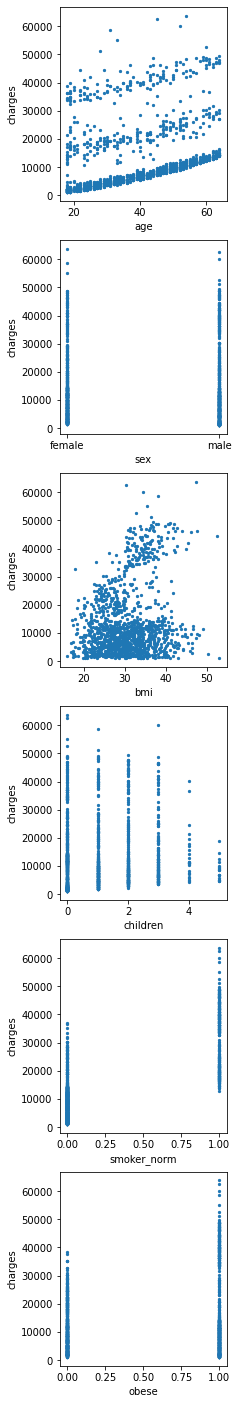

In [ ]:
colnum=len(insurance.columns)-3
fig,ax=plt.subplots(colnum,1,figsize=(3,25))
ax[0].set_ylabel("charges")
p_vals={}
for ind,col in enumerate([i for i in insurance.columns if i not in ["smoker","region","charges","sex_norm"]]):
    
    ax[ind].scatter(insurance[col],insurance.charges,s=5)
    ax[ind].set_xlabel(col)
    ax[ind].set_ylabel("charges")    
plt.show()

age :  0.2990081933306476
bmi :  0.1983409688336288
children :  0.0679982268479048
charges :  1.0
smoker_norm :  0.7872514304984775
obese :  0.19968322199588243


Text(0, 0.5, 'Absolute correlation')

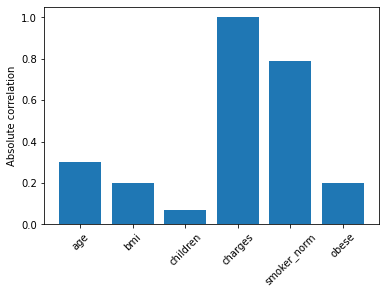

In [ ]:
corr_vals=[]
collabel=[]
for col in [i for i in insurance.columns if i not in nonnum_cols]:
    
    p_val=sp.stats.pearsonr(insurance[col],insurance["charges"])
    corr_vals.append(np.abs(p_val[0]))
    print(col,": ",np.abs(p_val[0]))
    collabel.append(col)
plt.bar(range(1,len(corr_vals)+1),corr_vals)
plt.xticks(range(1,len(corr_vals)+1),collabel,rotation=45)
plt.ylabel("Absolute correlation")

### Apparently, smoking, age and obesity are the factors that contribute the most in the calculation of insurance costs. We will only use those features for our predictions.

In [ ]:
cols_not_reg3=['age', 'obese', 'smoker_norm']

We will make our predictions using Linear Regression, for which we will model the relationship between the three variables and insurance costs  by fitting a linear equation to observed data. <br>
We will assume that the model for multiple linear regression, given n=3 observations, is : <br>
y = a*x1 + b*x2 + c*x3 + i <br>
where:<br>
y is the health insurance cost <br>
a is the age penalty <br>
b is the obesity penalty, while x2 will accept a value of 1 for obese individuals and 0 for non-obese ones. <br>
c is the penalty to smokers, for which x3 will have a value of 1 <br>
i is the intercept of the equation <br>

### We will make our predictions using K-fold cross validation
In k-fold cross-validation, we create the testing and training sets by splitting the data into **k** equally sized subsets. We then treat a single subsample as the testing set, and the remaining data as the training set. We then run and test models on all **k** datasets, and average the estimates. Let’s try it out with 10 folds and using Linear Regression:

In [ ]:
kf=KFold(n_splits=10, random_state=1, shuffle=True)
intercepts=[]
mses=[]
coefs=[]

for train_index, test_index in kf.split(insurance[cols_not_reg3]):
    
    lr=linear_model.LinearRegression()
    lr.fit(insurance[cols_not_reg3].iloc[train_index],insurance["charges"].iloc[train_index])
    lr_predictions=lr.predict(insurance[cols_not_reg3].iloc[test_index])
    
    lr_mse=mean_squared_error(insurance["charges"].iloc[test_index],lr_predictions)
    
    intercepts.append(lr.intercept_)
    
    coefs.append(lr.coef_)
    mses.append(lr_mse)
    

In [ ]:
rmses=[x**.5 for x in mses]
avg_rmse=np.mean(rmses)
avg_intercept=np.mean(intercepts)
age_coefs=[]
obesity_coefs=[]
smoking_coefs=[]
for vals in coefs:
    #print vals[0]
    age_coefs.append(vals[0])
    obesity_coefs.append(vals[1])
    smoking_coefs.append(vals[2])
age_coef=np.mean(age_coefs)
obesity_coef=np.mean(obesity_coefs)
smoking_coef=np.mean(smoking_coefs)
print("a: ",age_coef," b: ",obesity_coef," c: ",smoking_coef," intercept: ",avg_intercept)

a:  261.83801848327676  b:  4227.7376009403615  c:  23851.06705386572  intercept:  -4107.422133255812


### After we obtain the LR coefficients, we define a function that will automatically predict a insurance cost value given age, obesity and smoking parameters

In [ ]:
def calculate_insurance(age,obesity,smoking):
    y=(age_coef*age)+(obesity_coef*obesity)+(smoking_coef*smoking)+avg_intercept
    return y

### For example, a 34 year old, obese and smoker individual will have to pay the following price for his insurance:

In [ ]:
print(calculate_insurance(30,20,1))

112153.53749391544
